In [1]:
import osmnx as ox
import shapely
import requests
import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline

In [2]:
def convert_coordinates(eas,nor):
    # This function converts vl95 coordinates to wgs84 coordinates using an API from swisstopo
    import os

    api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(nor,eas)

    response = requests.get(api_url)
    return(float(response.json()['easting']),float(response.json()['northing']))

    return(koord_df_wgs84)

In [3]:
def save_numpy_array(np_arr,SAVEFILE_NAME):
    # This function stores the numpy array in the current directory
    with open('./{}.npy'.format(SAVEFILE_NAME), 'wb') as f:
        np.save(f, np_arr)
    return()

def load_numpy_array(SAVEFILE_NAME):
    # This function loads the numpy array from the current directory
    with open('./{}.npy'.format(SAVEFILE_NAME), 'rb') as f:
        return(np.load(f)) 

def convert_coordinates_multiple(koord_df,SAVEFILE_NAME):
    # This function converts vl95 coordinates to wgs84 coordinates using an API from swisstopo
    import os

    if os.path.exists('./{}.npy'.format(SAVEFILE_NAME)):
        koord_df_wgs84 = load_numpy_array(SAVEFILE_NAME)

    else:
        koord_df_wgs84 = np.empty(koord_df.shape,dtype='float')
        for i in range(koord_df.shape[0]):

            api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(koord_df[i,1],koord_df[i,0])

            response = requests.get(api_url)
            koord_df_wgs84[i,0] = float(response.json()['easting'])
            koord_df_wgs84[i,1] = float(response.json()['northing'])

            save_numpy_array(koord_df_wgs84,SAVEFILE_NAME)
    return(koord_df_wgs84)

<AxesSubplot:>

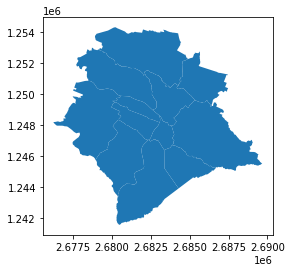

In [5]:
# Set filepath
fp = "../data/raw/stzh.adm_stadtkreise_a.shp"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

data.plot()

<AxesSubplot:>

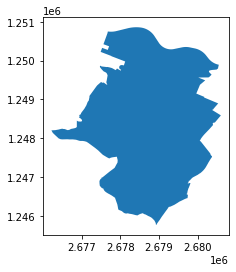

In [29]:
data[data.name == 9.0].plot()

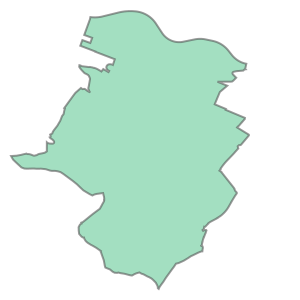

In [105]:
poly = data[data.name == 9.0].geometry[6]
poly

In [98]:
xx = []
yy = []
for c in poly.exterior.coords:
    c_ = convert_coordinates(c[1],c[0])
    #print(c_)
    xx.append(c_[0])
    yy.append(c_[1])

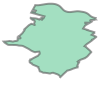

In [101]:
poly_new = shapely.geometry.Polygon(zip(xx,yy))
poly_new

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


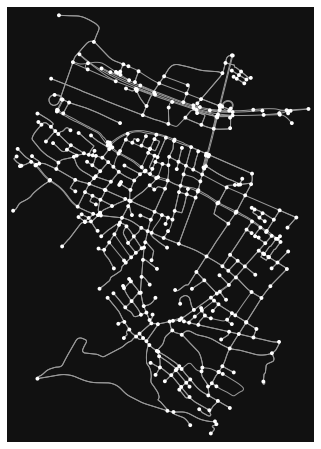

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [219]:
G = ox.graph_from_polygon(poly_new, network_type='drive') #'walk'
ox.plot_graph(G)

# network needs to be bit larger in order to avoid weakly connected model

In [230]:
bounds = poly.bounds
bounds

(2676224.694, 1245766.691, 2680586.018654951, 1250860.391)

In [231]:
convert_coordinates(bounds[1],bounds[0])

(8.447603623951219, 47.35834061900655)

In [232]:
convert_coordinates(bounds[3],bounds[2])

(8.506244330975884, 47.4036315748066)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


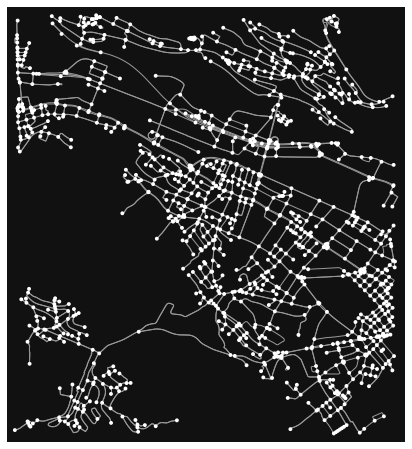

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [258]:
G = ox.graph_from_bbox(47.35834061900655, 47.4096315748066, 8.447603623951219, 8.516244330975884, network_type='drive') # bike
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

# Adressen:

In [298]:
# Read dataset 'Adressen'

PATH_ADRESSEN = '/Users/Derk/Desktop/DS Zürich/Adressen/data/geoz.adrstzh_adressen_stzh_p.csv'
df_adressen=pd.read_csv(PATH_ADRESSEN)

# Rename coordinates
df_adressen.rename(columns={"hausnummer_koord_ost":"koord_ost","hausnummer_koord_nord":"koord_nord"},inplace=True)

#df_adressen.head()

In [299]:
df_adressen = df_adressen[df_adressen.stadtkreis == 9]

In [300]:
koord_adressen = df_adressen[['koord_nord','koord_ost']].to_numpy()
SAVEFILE_NAME = 'Koordinaten_Adressen_WGS84'
koord_adressen_wgs84 = convert_coordinates_multiple(koord_adressen,SAVEFILE_NAME)

In [301]:
adresses = pd.DataFrame(koord_adressen_wgs84,columns=["x","y"])
adresses

,x,y
0,8.488178,47.381380
1,8.488689,47.381916
2,8.488650,47.382898
3,8.488726,47.383038
4,8.488812,47.383269
...,...,...
6570,8.498992,47.393103
6571,8.484023,47.399317
6572,8.484081,47.399798
6573,8.484254,47.399615


# Plot adresses and network

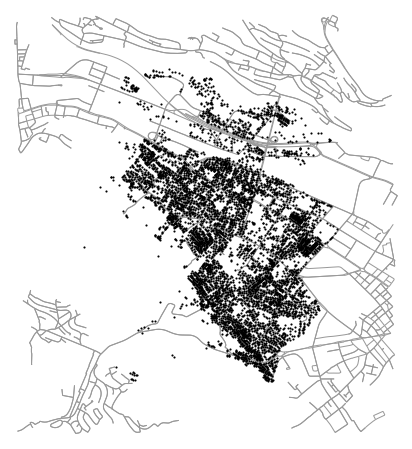

In [313]:
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c='k', marker='.', s=5, zorder=3)

fig.canvas.draw()
fig

# Regular spatial clustering

In [199]:
from sklearn.cluster import DBSCAN

# parameterize DBSCAN
eps = 300 #meters
minpts = 3 #smallest cluster size allowed

In [200]:
%%time
# compute DBSCAN using straight-line haversine distances
eps_rad = eps / 3671000. #meters to radians
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric='haversine', algorithm='ball_tree')
adresses['spatial_cluster'] = db.fit_predict(np.deg2rad(adresses[['y', 'x']]))

CPU times: user 1.84 s, sys: 70.5 ms, total: 1.91 s
Wall time: 1.94 s


In [201]:
len(adresses['spatial_cluster'].unique())

3

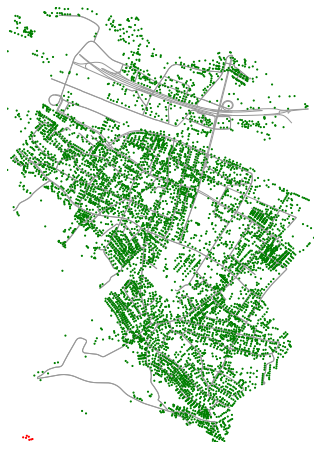

In [202]:
# plot adresses by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'m', 3:'b'}
point_colors = [color_map[c] for c in adresses['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=point_colors, marker='.', s=5, zorder=3)
fig.canvas.draw()
fig

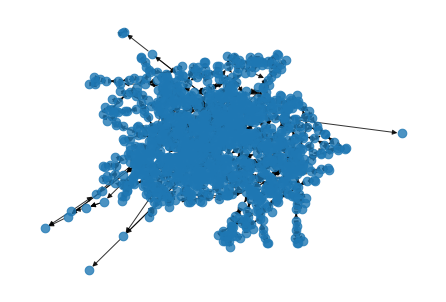

In [353]:
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size = 75, alpha = 0.8) 
#, pos,

In [361]:
nx.is_weakly_connected(G)

True

# Regular spatial clustering (kmeans)

In [260]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="random",n_clusters=30,n_init=10,max_iter=300,random_state=42)

In [314]:
#kmeans.fit(np.deg2rad(adresses[['y', 'x']]))


kmeans.fit(adresses[['y', 'x']])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=20, n_clusters=30,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [315]:
adresses['spatial_cluster'] = kmeans.labels_
len(adresses['spatial_cluster'].unique())

30

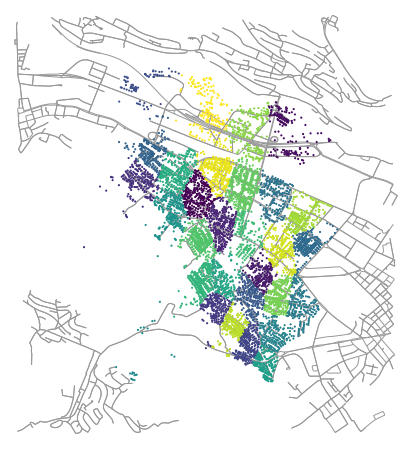

In [316]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'m', 3:'b'}
# point_colors = [color_map[c] for c in adresses['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['spatial_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
fig

# Attach nearest node to each adress then make network-based distance matrix

In [323]:
import networkx as nx

# attach nearest network node to each adresses
adresses['nn'] = ox.nearest_nodes(G, X=adresses['x'], Y=adresses['y'])
print(len(adresses['nn']))

# we'll get distances for each pair of nodes that have adresses attached to them
nodes_unique = pd.Series(adresses['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

6575
450


In [456]:
np.unique(adresses["nn"], return_index=True)[1].tolist()

[3641,
 6365,
 3602,
 4305,
 2014,
 4200,
 0,
 3330,
 3351,
 6179,
 5607,
 5601,
 4674,
 4660,
 5620,
 6103,
 6147,
 6165,
 2906,
 3371,
 1587,
 1518,
 1583,
 1535,
 1525,
 1545,
 1544,
 1538,
 566,
 1621,
 1528,
 1698,
 146,
 1735,
 115,
 572,
 557,
 562,
 591,
 78,
 582,
 560,
 787,
 63,
 189,
 227,
 192,
 243,
 809,
 471,
 4405,
 4353,
 4365,
 4412,
 820,
 822,
 807,
 808,
 301,
 299,
 4415,
 4352,
 4413,
 3170,
 352,
 390,
 784,
 856,
 3247,
 3875,
 383,
 394,
 347,
 343,
 449,
 2528,
 2476,
 2369,
 346,
 2467,
 2374,
 2376,
 2407,
 1804,
 2368,
 2136,
 2072,
 2089,
 2164,
 499,
 554,
 3604,
 3808,
 5630,
 1900,
 1853,
 1141,
 1781,
 2372,
 305,
 307,
 3184,
 323,
 638,
 1892,
 3312,
 8,
 5,
 1838,
 1916,
 1919,
 1846,
 1855,
 3172,
 2375,
 3689,
 3676,
 3661,
 3047,
 3088,
 3046,
 3975,
 3867,
 4096,
 4104,
 4101,
 4220,
 3511,
 4859,
 1359,
 2841,
 2126,
 1161,
 1183,
 6441,
 6371,
 6376,
 6480,
 426,
 3600,
 3614,
 3634,
 3901,
 3893,
 3731,
 4114,
 3680,
 4198,
 4112,
 4098,
 2

In [377]:
nodes_unique

4366131          4366131
63018530        63018530
63015774        63015774
157356494      157356494
475361826      475361826
                 ...    
84481310        84481310
617309711      617309711
84481305        84481305
84481311        84481311
1469099820    1469099820
Length: 450, dtype: int64

In [265]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
    
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [ ]:
####################### TRY TO RESOLVE 'NetworkXNoPath: Node 5082713974 not reachable from 4366131' whn using 'drive' network

In [221]:
"""# suggestion 1

# nodes_unique = pd.Series(adresses['nn'].unique()) 
# nodes_unique.index = nodes_unique.values 
nodes_unique = list(nx.weakly_connected_components(G))
print(len(nodes_unique))"""

1


In [216]:
"""# OPTION 2: use a strongly (instead of weakly) connected graph
G_dm_s = ox.utils_graph.get_largest_component(G_dm, strongly=True)"""

In [ ]:
"""# OPTION 1: recursively remove unsolvable origin/destination nodes and re-try
G2 = G_dm.copy()
solved = False
while not solved:
    try:
        orig_node = ox.get_nearest_node(G2, orig_point)
        dest_node = ox.get_nearest_node(G2, dest_point)
        print(nx.shortest_path_length(G2, orig_node, dest_node, weight='length'))
        solved = True
    except nx.exception.NetworkXNoPath:
        G2.remove_nodes_from([orig_node, dest_node])"""

In [ ]:
###########

In [266]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
#node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm_s)
node_dm = node_dm.astype(int)
print(node_dm.size)

202500
CPU times: user 5min 21s, sys: 2.16 s, total: 5min 23s
Wall time: 5min 26s


In [ ]:
#####

# Make distance matrix sparse

In [450]:
adresses

,x,y,network_cluster,spatial_cluster,nn
0,8.488178,47.381380,0,20,4366131
1,8.488689,47.381916,0,20,4366131
2,8.488650,47.382898,0,20,4366131
3,8.488726,47.383038,0,20,4366131
4,8.488812,47.383269,0,20,4366131
...,...,...,...,...,...
6570,8.498992,47.393103,0,1,71324897
6571,8.484023,47.399317,0,29,524694907
6572,8.484081,47.399798,0,29,524694907
6573,8.484254,47.399615,0,29,524694907


In [378]:
node_dm

,4366131,63018530,63015774,157356494,475361826,157357338,147582298,147580871,27005690,142129767,...,4366139,481443850,142121201,453810,84481306,84481310,617309711,84481305,84481311,1469099820
4366131,1,292,0,0,233,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63018530,292,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63015774,0,0,1,85,119,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157356494,0,0,85,1,205,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475361826,233,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84481310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,113,1,175,88,32,0
617309711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,61,175,1,114,208,0
84481305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,52,88,114,1,121,0
84481311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,146,32,208,121,1,0


In [267]:
from scipy.sparse import csr_matrix

node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [268]:
# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=adresses['nn'], columns=adresses['nn'])
print('{:,.0f}'.format(ndm.size))

43,230,625


In [380]:
adresses['nn'].shape

(6575,)

In [381]:
nodes_unique.shape

(450,)

In [379]:
ndm.shape

(6575, 6575)

In [382]:
ndm_sparse.shape

(6575, 6575)

In [269]:
%%time
# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)

CPU times: user 394 ms, sys: 25.4 ms, total: 419 ms
Wall time: 428 ms


In [270]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.to_numpy().nbytes / 1e6
dense_size

345.845

In [271]:
# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6
sparse_size

11.317548

# Cluster adresses along the network (DBSCAN)

In [390]:
# parameterize DBSCAN
eps = 50 #meters
minpts = 220 #smallest cluster size allowed

In [391]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
adresses['network_cluster'] = db.fit_predict(ndm_sparse)

CPU times: user 46.1 ms, sys: 43.3 ms, total: 89.4 ms
Wall time: 169 ms


In [392]:
len(adresses['network_cluster'].unique())

1

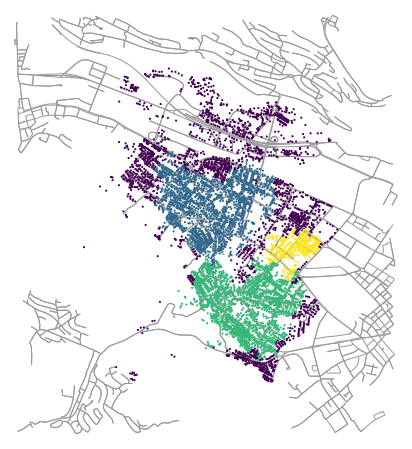

In [288]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
fig

# Cluster adresses along the network (kmedoids)

In [407]:
# from sklearn_extra.cluster import KMedoids

# kmedoids = KMedoids(n_clusters=30, random_state=14,metric='precomputed')

# #kmedoids.fit(ndm_sparse)
# kmedoids.fit(ndm)


# # kmeans = KMeans(init="random",n_clusters=30,n_init=10,max_iter=20,random_state=42)
# # kmeans.fit(ndm_sparse)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

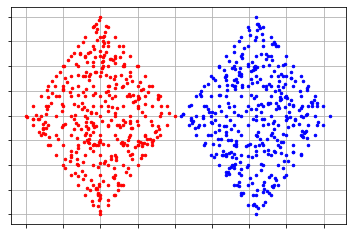

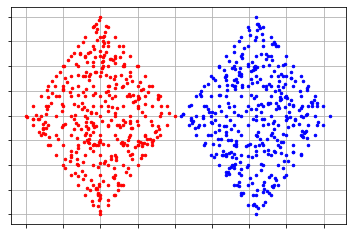

In [410]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
# Set random initial medoids.
initial_medoids = [1, 500]
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(sample, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
print(clusters)
# Display clusters.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.show()

In [425]:
from pyclustering.utils import calculate_distance_matrix

matrix = calculate_distance_matrix(sample)

In [433]:
from pyclustering.cluster.kmedoids import kmedoids
import numpy as np

dm = np.array(
    [[0.,1.91,2.23,3.14,4.25,3.37],
    [0.,0.,2.15,1.82,2.41,2.58],
    [0.,0.,0.,3.12,3.83,4.64],
    [0.,0.,0.,0.,1.9,2.66],
    [0.,0.,0.,0.,0.,3.12],
    [0.,0.,0.,0.,0.,0.]])
dm = dm + np.transpose(dm)
k = 2
# choose medoid 2 and 4 in your C1 and C2 because min(D) in their cluster
#initial_medoids = [1,3]

####
import random

randomlist = random.sample(range(0, 6), k)
initial_medoids = randomlist
####

kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()
print(clusters)
# [[1, 0, 2, 5], [3, 4]]
print(centers)
# [1, 3]

[[0, 1, 2, 3, 5], [4]]
[1, 4]


In [482]:
# try it on actual data:

from pyclustering.cluster.kmedoids import kmedoids
import numpy as np

# dm = np.array(
#     [[0.,1.91,2.23,3.14,4.25,3.37],
#     [0.,0.,2.15,1.82,2.41,2.58],
#     [0.,0.,0.,3.12,3.83,4.64],
#     [0.,0.,0.,0.,1.9,2.66],
#     [0.,0.,0.,0.,0.,3.12],
#     [0.,0.,0.,0.,0.,0.]])
# dm = dm + np.transpose(dm)

dm = ndm.to_numpy()

k = 30
# choose medoid 2 and 4 in your C1 and C2 because min(D) in their cluster
#initial_medoids = [1,3]

####
import random
random.seed(10)
#randomlist = random.sample(range(0, dm.shape[0]), k)
randomlist = random.sample(np.unique(adresses["nn"], return_index=True)[1].tolist(),k)

initial_medoids = randomlist
####
initial_medoids = [0,500,1000,1500,4000,3201,5001]

kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()
print(clusters)
# [[1, 0, 2, 5], [3, 4]]
print(centers)
# [1, 3]

[[8, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 22, 23, 24, 35, 36, 37, 41, 42, 43, 44, 46, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 2

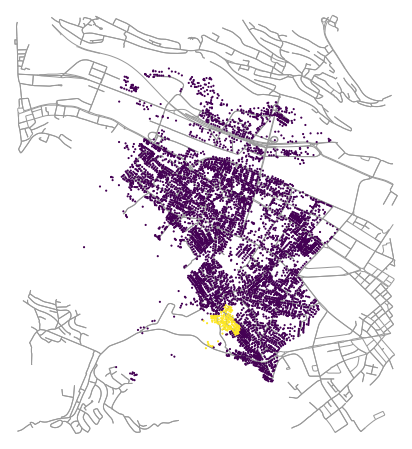

In [466]:
# asign cluster to each adress
for i,c in enumerate(clusters):
#c = clusters[0]
    adresses.loc[c,'network_cluster'] = i

# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
fig


In [480]:
# does this kmedoids implementation even work? test using euclidian distances

from pyclustering.cluster.kmedoids import kmedoids
import numpy as np

# dm = np.array(
#     [[0.,1.91,2.23,3.14,4.25,3.37],
#     [0.,0.,2.15,1.82,2.41,2.58],
#     [0.,0.,0.,3.12,3.83,4.64],
#     [0.,0.,0.,0.,1.9,2.66],
#     [0.,0.,0.,0.,0.,3.12],
#     [0.,0.,0.,0.,0.,0.]])
# dm = dm + np.transpose(dm)

dm = ndm.to_numpy()

k = 30
# choose medoid 2 and 4 in your C1 and C2 because min(D) in their cluster
#initial_medoids = [1,3]

####
import random
random.seed(10)
#randomlist = random.sample(range(0, dm.shape[0]), k)
randomlist = random.sample(np.unique(adresses["nn"], return_index=True)[1].tolist(),k)

initial_medoids = randomlist
initial_medoids = [0,500,1000,1500,4000,3201,5001]
####

kmedoids_instance = kmedoids(adresses[['y', 'x']].to_numpy(), initial_medoids) # , data_type = 'distance_matrix'
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()
print(clusters)
# [[1, 0, 2, 5], [3, 4]]
print(centers)
# [1, 3]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 298, 334, 337, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 354, 355, 356, 357, 358, 360, 379, 380, 381, 453, 457, 462, 474, 477, 481, 482, 491, 506, 515, 516, 517, 518, 520, 524, 536, 538, 540, 541, 542, 543, 547, 548, 549, 551, 553, 554, 555, 556, 564, 576, 577, 578, 579, 581, 609, 629, 630, 631, 632, 633, 634, 635, 636, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 673, 674, 675, 678, 685, 688, 689, 690, 697, 699, 700, 701, 702, 703, 704, 705, 718, 725, 726, 732, 733, 734, 735, 736, 737, 739, 741, 742, 744, 745, 751, 752, 753, 754, 755, 757, 758, 759, 769, 772, 776, 782, 783, 1516, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1529, 1530, 1

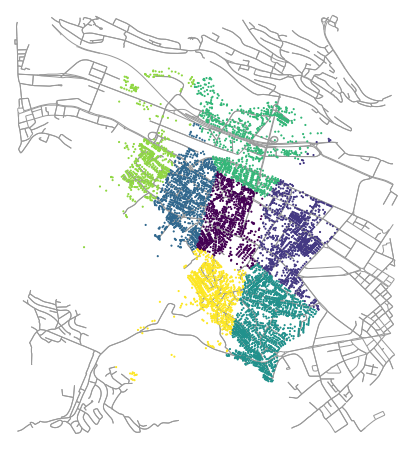

In [481]:
# asign cluster to each adress
for i,c in enumerate(clusters):
#c = clusters[0]
    adresses.loc[c,'network_cluster'] = i

# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
fig


In [421]:
from pyclustering.cluster.kmedoids import kmedoids
import random

randomlist = random.sample(range(10, 300), 30)
initial_medoids = randomlist

# create K-Medoids algorithm for processing distance matrix instead of points
kmedoids_instance = kmedoids(ndm_sparse, initial_medoids, data_type='distance_matrix')
# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
#medoids = kmedoids_instance.get_medoids()
clusters

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [403]:
adresses['network_cluster'] = kmedoids.labels_
len(adresses['network_cluster'].unique())

2

In [404]:
adresses['network_cluster'].value_counts()

0    6573
1       2
Name: network_cluster, dtype: int64

In [405]:
#adresses = adresses[adresses['network_cluster']==5]

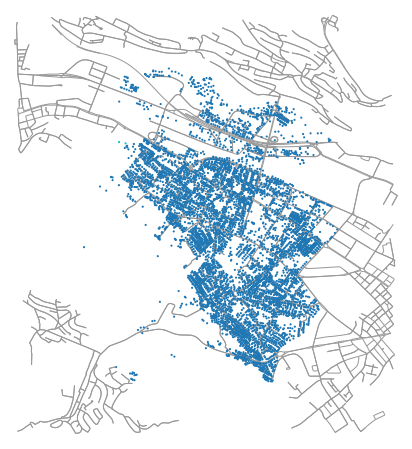

In [406]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3,cmap="tab10")
fig.canvas.draw()
fig

# k-medoids (spatial clustering)

In [386]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=30, random_state=0)

#kmedoids.fit(ndm_sparse)
kmedoids.fit(adresses[['y', 'x']])

KMedoids(init='heuristic', max_iter=300, method='alternate', metric='euclidean',
         n_clusters=30, random_state=0)

In [387]:
adresses['network_cluster'] = kmedoids.labels_
len(adresses['network_cluster'].unique())

30

In [349]:
adresses['network_cluster'].value_counts()

28    501
5     483
3     371
4     350
13    322
17    307
12    290
22    257
25    249
7     235
24    234
6     215
26    194
23    194
15    192
1     181
8     180
11    173
29    173
0     166
21    162
27    159
20    153
14    137
18    134
10    127
16    123
19    117
2     105
9      91
Name: network_cluster, dtype: int64

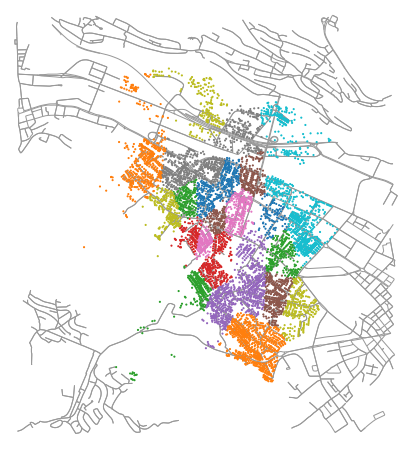

In [350]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3,cmap="tab10")
fig.canvas.draw()
fig

# community clustering

In [357]:
from community import community_louvain

In [385]:
#G_ = G.to_undirected()

comms = community_louvain.best_partition(ndm_sparse)

comms

AttributeError: is_directed not found

In [373]:
G_.number_of_nodes()

1183

In [374]:
G.number_of_nodes()

1183

In [370]:
len(comms)

1183

In [369]:
ndm_sparse

<6575x6575 sparse matrix of type '<class 'numpy.int64'>'
	with 940937 stored elements in Compressed Sparse Row format>

In [365]:
adresses['network_cluster'] = comms.values()

ValueError: Length of values (1183) does not match length of index (6575)

# Save

In [ ]:
# save the graph to disk
ox.save_graph_geopackage(G, filepath='data/graph.gpkg')

In [ ]:
# save and show the clustered adresses data set
adresses = adresses.reindex(columns=['x', 'y', 'nn', 'spatial_cluster', 'network_cluster'])
adresses.to_csv('data/clustered.csv', encoding='utf-8', index=False)
adresses[10:15]